# Process Discovery using pm4py
<hr>

Process mining includes three major fields:
- Process discovery
- Conformance Checking
- Process Improvement
<img src="https://www.researchgate.net/profile/Wil-Aalst/publication/298144668/figure/fig1/AS:843252890599424@1578058564571/There-are-three-basic-types-of-process-mining-a-process-discovery-techniques.png" style="height:200px">

#### Process Discovery:

A process discovery algorithm is a function that maps event log L onto a process model such that the model is “representative” for the behavior seen in the event log.

A suitable process model describes the order of events/activities that are executed during a process execution.

3 common process discovery algorithms:
1. Alpha miner
2. Heuristic mining
3. Inductive mining

## 1. Alpha miner
<hr>
The alpha miner is one of the most known Process Discovery algorithm and is able to find:

- A Petri net model where all the transitions are visible and unique and correspond to classified events (for example, to activities).
- An initial marking that describes the status of the Petri net model when a execution starts.
- A final marking that describes the status of the Petri net model when a execution ends.

<hr>
Input for the α-algorithm is a simple event log L over A , i.e., L ∈ B(A*).

- A = set of activities
- A* = set of sequences of activities in A
- B(A*) = Bag (multiset) of sequences

These activities will correspond to transitions in the discovered Petri net.

The output of the α-algorithm is a marked Petri net, i.e., α(L) = (N,M). where M = set of markings

<hr>

- The α-algorithm scans the event log for particular patterns.

- There are four log-based ordering relations that aim to capture relevant patterns in the log:
    1. a > b means a is directly followed by b
    2. a → b means there is a causal dependency, a is directly followed by b and b isn't directly followed by a.
    3. a#b means a and b are not directly followed by each other.
    4. a||b means a is dirertly follwed by b and b is directly followed by a in the trace.
    

- A footprint matrix is formed using these relations which gives the pairs of activities with causal dependencies which can be used to get the places p(A,B).

- We aim at constructing places named p(A,B) such that 
    - A is the set of input transitions (•p(A,B) = A) and 
    - B is the set of output transitions (p(A,B)• = B) of p(A,B).
    
    
- All start transitions in TI have iL as an input place and all end transitions TO have oL as output place. All places p(A,B) have A as input nodes and B as output nodes. The result is a Petri net α(L) = (PL,TL,FL) that describes the behavior seen in event log L.

#### Example
In this example, we read a log then the Alpha algorithm is applied and the Petri net along with the initial and the final marking are found.

In [2]:
import os

In [3]:
from pm4py.objects.log.importer.xes import importer as xes_importer
path = os.path.join("running-example.xes")

log = xes_importer.apply(path)

parsing log, completed traces ::   0%|          | 0/6 [00:00<?, ?it/s]

In [4]:
#applying the alpha miner
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
petri_net, initial_marking, final_marking = alpha_miner.apply(log)

## 2. Inductive Miner
<hr>
The Inductive Miner splits the event log into sublogs by detecting a 'cut' in the log (e.g. sequential cut, parallel cut, concurrent cut and loop cut) and then repeat on sublogs, which were found applying the cut, until a base case is found. 

The Directly-Follows variant avoids the recursion on the sublogs but uses the Directly Follows graph.

- Inductive miner models usually make extensive use of hidden transitions (silent transition - tau, which is not labelled and not associated with any activity), especially for skipping/looping on a portion on the model. 
- Furthermore, each visible transition has a unique label (there are no transitions in the model that share the same label).

Two process models can be derived: Petri Net and Process Tree.

#### Petri Net

In [5]:
from pm4py.algo.discovery.inductive import algorithm as inductive_miner

In [6]:
net, initial_marking, final_marking = inductive_miner.apply(log)

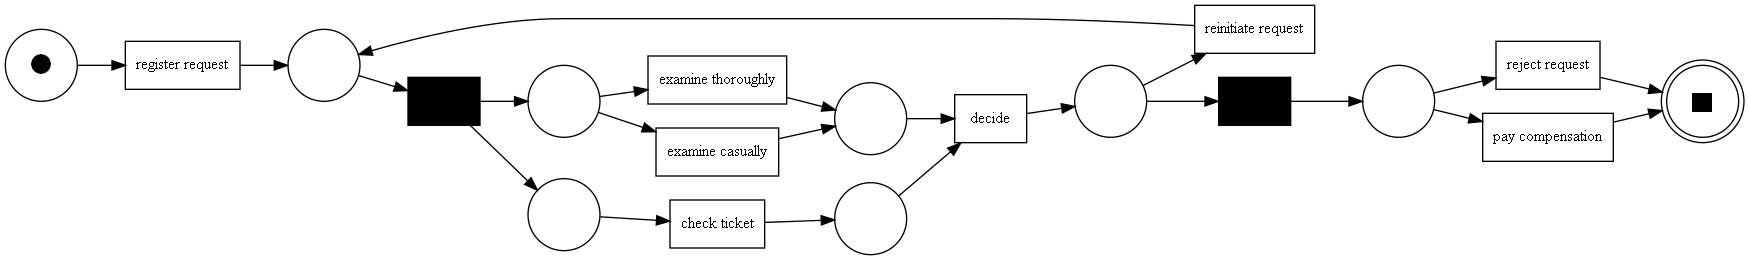

In [8]:
from pm4py.visualization.petri_net import visualizer as pn_visualizer
gviz1 = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz1)

- Circles represent places which have tokens
- Squares are transitions
- Black solid squares are silent transitions (tau)

#### Process Trees

In [9]:
from pm4py.visualization.process_tree import visualizer as pt_visualizer

tree = inductive_miner.apply_tree(log)

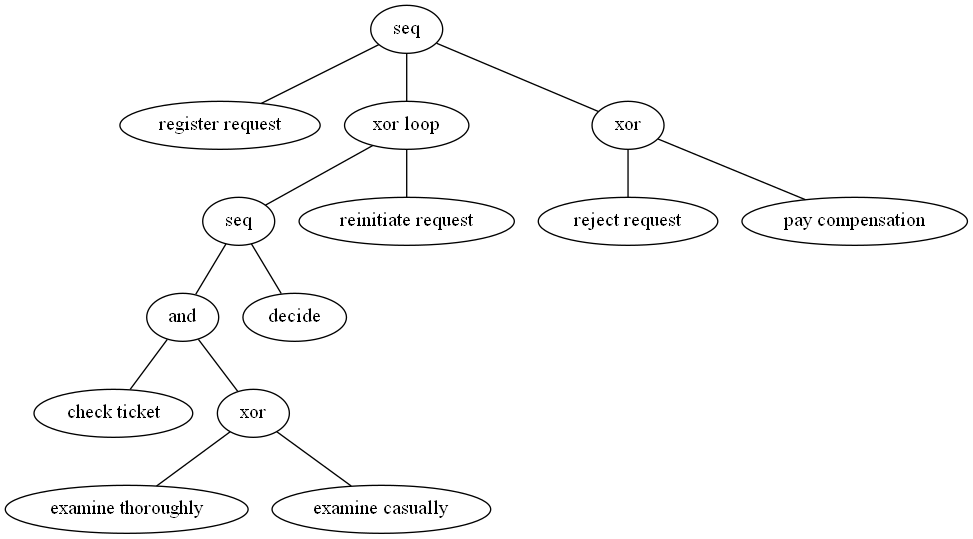

In [10]:

#visualizing the process tree using gviz
gviz = pt_visualizer.apply(tree)
pt_visualizer.view(gviz)

We can convert a process tree into a Petri Net as follows:

In [11]:
from pm4py.objects.conversion.process_tree import converter as pt_converter
net2, initial_marking, final_marking = pt_converter.apply(tree, variant=pt_converter.Variants.TO_PETRI_NET)

The 3 variants of inductive miner are:
1. Inductive Miner: produces model with perfect replay fitness.
2. Inductive Miner infrequent: produces a more precise model, without fitness guarantees, by eliminating some behavior.
3. Inductive Miner directly-follows: considers only the directly-follows graph, for maximum performance. However, replay fitness guarantees are lost.

## 3. Heuristic miner
<hr>
These algorithms take frequencies of events and sequences into account when constructing a process model.

Heuristics Miner is an algorithm that acts on the Directly-Follows Graph, providing way to handle with noise and to find common constructs. 

The output of the Heuristics Miner is an Heuristics Net, an object that contains the activities and the relationships between them. The Heuristics Net can be then converted into a Petri net.

It is possible to obtain a Heuristic Net and a Petri Net.

<hr>

#### Dependency measure
|a ⇒ b| is the value of the dependency relation (dependency measure) between a and b:

<img src='https://i.postimg.cc/mgJ4zxXm/heuristic-mining-dependencymeasure.png' style="height:100px">

- |a ⇒L b| produces a value between −1 and 1.
- If |a ⇒L b| is close to 1, then there is a strong positive dependency between a and b, i.e., a is often the cause of b.
- A value close to 1 can only be reached if a is often directly followed by b but b is hardly ever directly followed by a.
- If |a ⇒L b| is close to −1, then there is a strong negative dependency between a and b, i.e., b is often the cause of a.
- There is a special case for |a ⇒L a|. If a is often followed by a this suggests a loop and a strong reflexive dependency.

#### Dependency Threshold
In a dependency graph only arcs are shown that meet certain thresholds which can be:
- frequency threshold (arc between x and y only if |x > y| ≥ ft)
- dependency threshold (arc between x and y only if |x ⇒ y| ≥ dt) (we mention it in the parameters)

#### Heuristics net

In [12]:
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
heu_net = heuristics_miner.apply_heu(log, 
                                     parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.6})

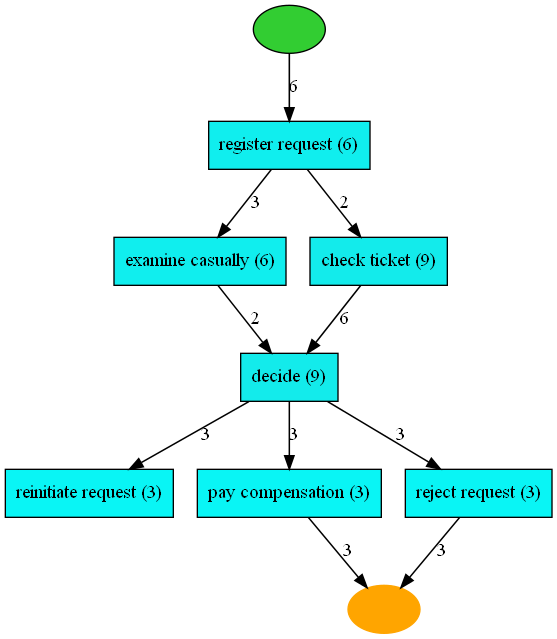

In [13]:
#visualizing the heuristics net
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
gviz_h = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz_h)

#### Petri Net

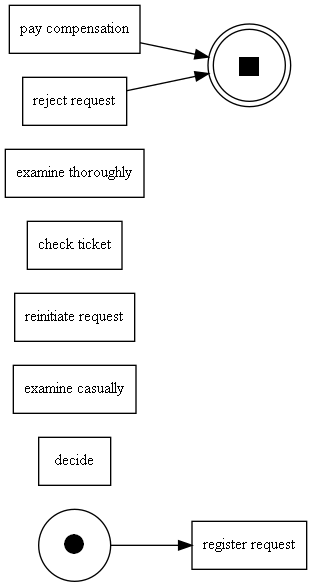

In [14]:
petri_net_heu, im, fm = heuristics_miner.apply(log, parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.99})

from pm4py.visualization.petri_net import visualizer as pn_visualizer
gviz_pn_h = pn_visualizer.apply(petri_net_heu, im, fm)
pn_visualizer.view(gviz_pn_h)

Here, we observe that a heuristics net better represents the process as it takes into account the frequency of sequences of events.